<a href="https://colab.research.google.com/github/Wishbert/Portfolio/blob/main/VGG16_Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The code below is meant to test the accuracy of the VGG16 model

Below is a classification of Malaria Cells. The dataset used contains images of the infected cells and unifected cells The images are of different sizes

In [4]:
!curl -O ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  337M  100  337M    0     0  26.4M      0  0:00:12  0:00:12 --:--:-- 32.3M


In [5]:
!unzip -q cell_images.zip

In [7]:
import os

In [8]:
num_skipped = 0
for folder_name in ("Parasitized", "Uninfected"):
    folder_path = os.path.join("cell_images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            png_true = 'png' in fname
        finally:
            fobj.close()

        if not png_true:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)


Deleted 2 images


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
image_size = (224, 224) #the images all have the same size 
batch_size = 32

#seeding is fixed to get a 'fixed' random data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cell_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cell_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [11]:
data_agumentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomRotation((-0.3,0.3)),
     layers.experimental.preprocessing.RandomZoom(0.5)
    ]
)

In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Building the Model

In [18]:
def VGG16_model(input_shape):
  inputs = keras.Input(shape = input_shape)
  print('inputs: ',inputs)
  #applying the agumentaions to my data
  agumented_output = data_agumentation(inputs)

  #rescaling as part of the model for GPU use
  rescaled_output = layers.experimental.preprocessing.Rescaling(1/255)(agumented_output)
  #convolutional blocks
  for filter_num in [64,128]:
    conv_output = layers.Conv2D(filter_num, 3, strides = 1, padding = 'same')(rescaled_output)
    norm_output = layers.BatchNormalization()(conv_output)
    actv_output = layers.Activation('relu')(norm_output)

    conv_output = layers.Conv2D(filter_num, 3, strides = 1, padding = 'same')(actv_output)
    norm_output = layers.BatchNormalization()(conv_output)
    actv_output = layers.Activation('relu')(norm_output)

    pool_output = layers.MaxPool2D(2,strides = 2)(actv_output)
    rescaled_output = pool_output

  rescaled_output = None #this variable served it purpose

  for filter_num in [256,512,512]:

    conv_output = layers.Conv2D(filter_num ,3, strides = 1, padding = 'same')(pool_output)
    norm_output = layers.BatchNormalization()(conv_output)
    actv_output = layers.Activation('relu')(norm_output)

    conv_output = layers.Conv2D(filter_num ,3, strides = 1, padding = 'same')(actv_output)
    norm_output = layers.BatchNormalization()(conv_output)
    actv_output = layers.Activation('relu')(norm_output)


    conv_output = layers.Conv2D(filter_num ,3, strides = 1, padding = 'same')(actv_output)
    norm_output = layers.BatchNormalization()(conv_output)
    actv_output = layers.Activation('relu')(norm_output)

    pool_output = layers.MaxPool2D(2,strides = 2)(actv_output)

  flatten_output = layers.Flatten()(pool_output)
  print('flattened: ',flatten_output)
  
  neuron_output = layers.Dense(256, activation = 'relu')(flatten_output)
  print('neuron: ',neuron_output)
  neuron_output = layers.Dense(256, activation = 'relu')(neuron_output)
  outputs = layers.Dense(2, activation = 'softmax')(neuron_output)
  print('outputs: ',outputs)

  return keras.Model(inputs,outputs)

inputs:  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
flattened:  KerasTensor(type_spec=TensorSpec(shape=(None, 25088), dtype=tf.float32, name=None), name='flatten_3/Reshape:0', description="created by layer 'flatten_3'")
neuron:  KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_9/Relu:0', description="created by layer 'dense_9'")
outputs:  KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense_11/Softmax:0', description="created by layer 'dense_11'")


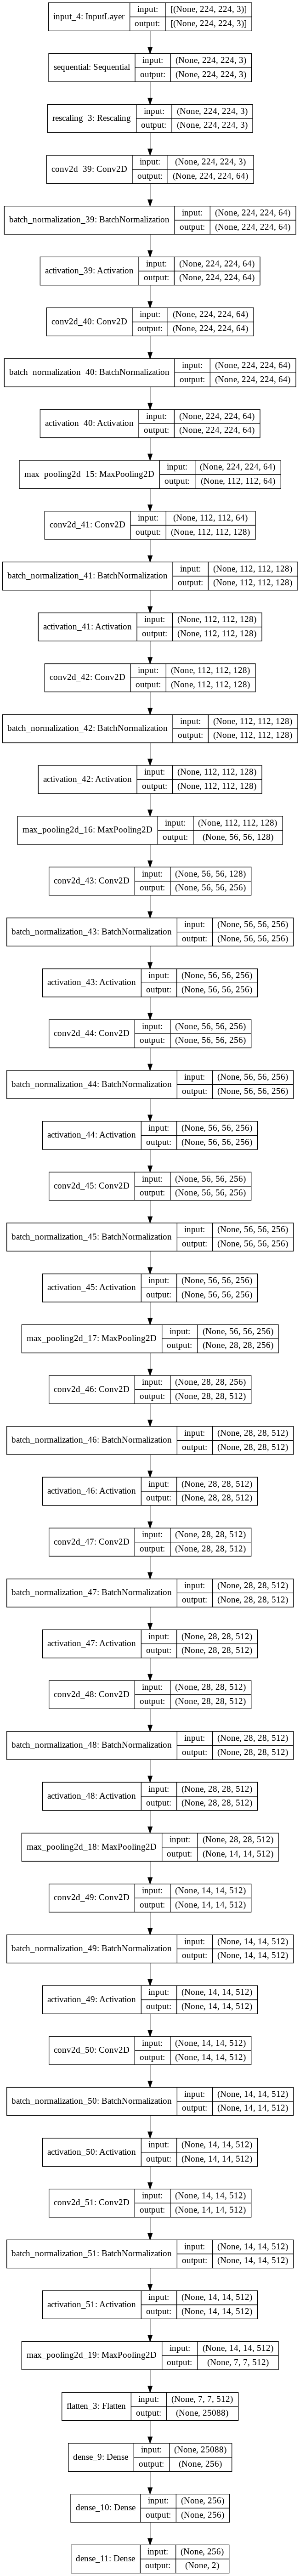

In [19]:
model = VGG16_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


NotImplementedError: ignored